In [13]:
# Import necessary libraries
import os
import sys
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
# Add the parent directory to the Python path
sys.path.append(os.path.abspath("../scripts"))
import db_config
from user_experience_analytics import UserExperienceAnalytics

In [14]:
# Fetch the data
from sklearn.discriminant_analysis import StandardScaler


QUERY = "SELECT * FROM xdr_data"
data = db_config.fetch_data(QUERY) 
df = pd.DataFrame(data)



In [15]:
# Convert necessary columns to numeric and handle missing data
columns_to_convert = [
    "Avg RTT DL (ms)", "Avg RTT UL (ms)", "Avg Bearer TP DL (kbps)", "Avg Bearer TP UL (kbps)",
    "TCP DL Retrans. Vol (Bytes)", "TCP UL Retrans. Vol (Bytes)"
]
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Replace NaN in numeric columns with column mean
df[columns_to_convert] = df[columns_to_convert].fillna(df[columns_to_convert].mean())

# Replace missing Handset Type with mode
df["Handset Type"] = df["Handset Type"].fillna(df["Handset Type"].mode()[0])

In [16]:
### **Task 3.1 - Aggregate Information per Customer**
aggregated_data = df.groupby('MSISDN/Number').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'TCP UL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean',
    'Handset Type': lambda x: x.mode().iloc[0] if not x.mode().empty else None
}).reset_index()

aggregated_data.rename(columns={
    'TCP DL Retrans. Vol (Bytes)': 'Avg TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)': 'Avg TCP UL Retrans. Vol (Bytes)',
    'Avg RTT DL (ms)': 'Avg RTT DL (ms)',
    'Avg RTT UL (ms)': 'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)': 'Avg Throughput DL (kbps)',
    'Avg Bearer TP UL (kbps)': 'Avg Throughput UL (kbps)'
}, inplace=True)


In [17]:
### **Task 3.2 - Compute & List 10 Top, Bottom, and Most Frequent Values**
def get_top_bottom_most_frequent(column):
    top_10 = column.nlargest(10)
    bottom_10 = column.nsmallest(10)
    most_frequent = column.value_counts().head(10)
    return top_10, bottom_10, most_frequent

tcp_values = df['TCP DL Retrans. Vol (Bytes)']
rtt_values = df['Avg RTT DL (ms)']
throughput_values = df['Avg Bearer TP DL (kbps)']

tcp_top, tcp_bottom, tcp_freq = get_top_bottom_most_frequent(tcp_values)
rtt_top, rtt_bottom, rtt_freq = get_top_bottom_most_frequent(rtt_values)
throughput_top, throughput_bottom, throughput_freq = get_top_bottom_most_frequent(throughput_values)

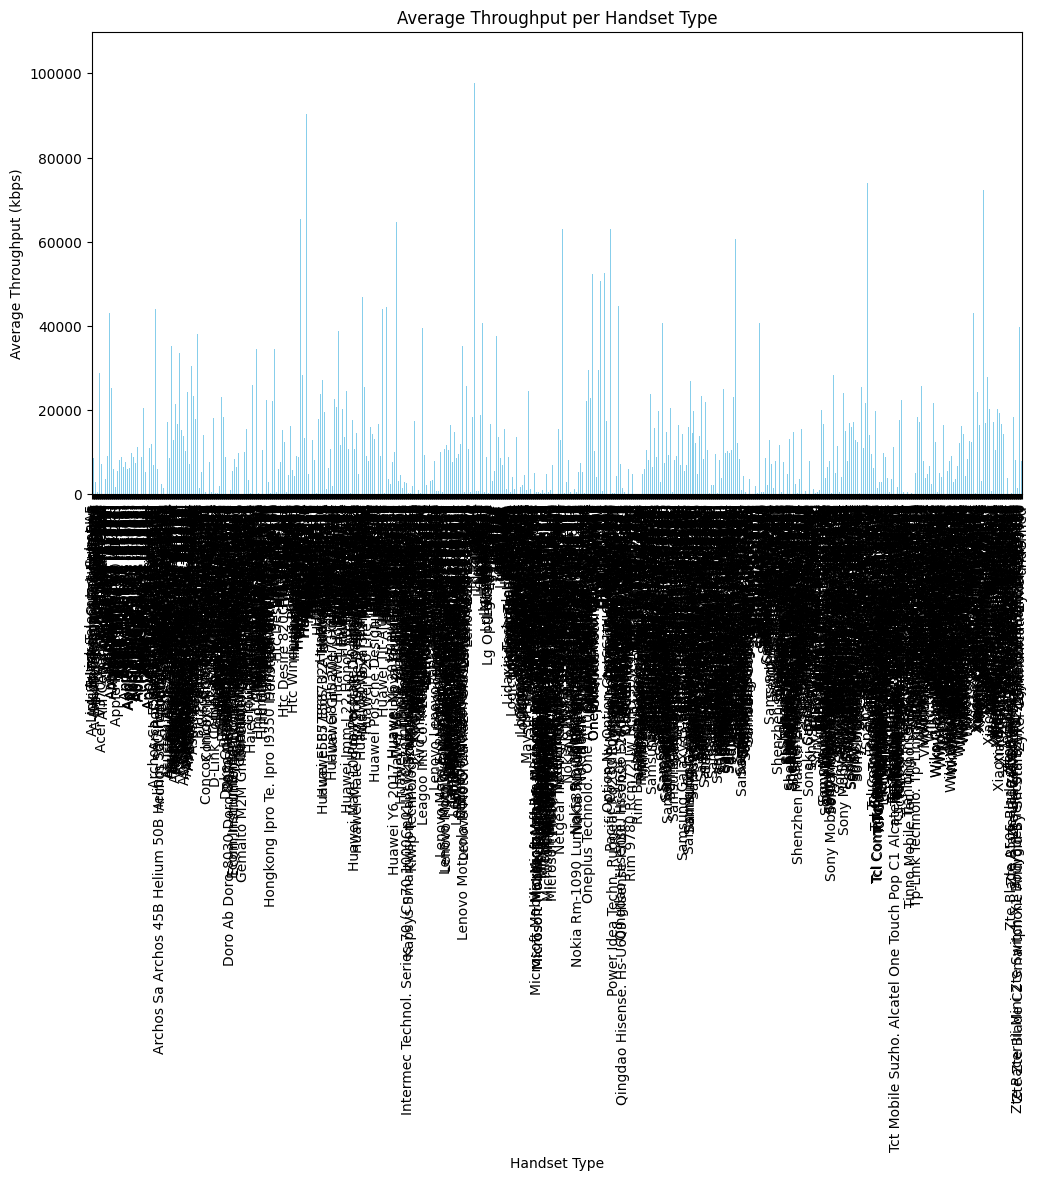

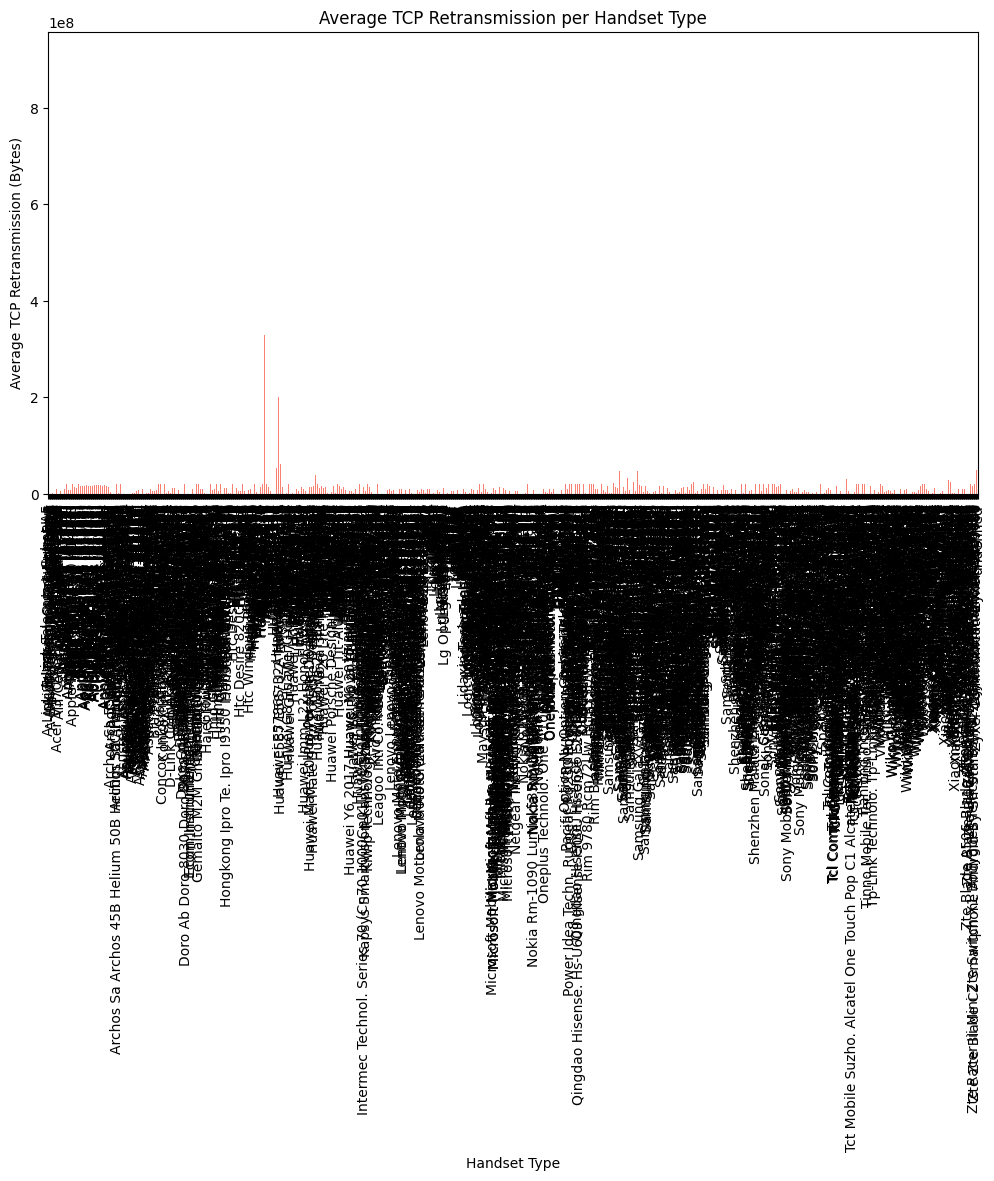

In [18]:
### **Task 3.3 - Distribution and Interpretation**

# Distribution of Average Throughput per Handset Type
throughput_distribution = aggregated_data.groupby('Handset Type')['Avg Throughput DL (kbps)'].mean()
throughput_distribution.plot(kind='bar', figsize=(12, 6), title='Average Throughput per Handset Type', color='skyblue')
plt.ylabel('Average Throughput (kbps)')
plt.xlabel('Handset Type')
plt.show()

# Average TCP Retransmission per Handset Type
tcp_retrans_distribution = aggregated_data.groupby('Handset Type')['Avg TCP DL Retrans. Vol (Bytes)'].mean()
tcp_retrans_distribution.plot(kind='bar', figsize=(12, 6), title='Average TCP Retransmission per Handset Type', color='salmon')
plt.ylabel('Average TCP Retransmission (Bytes)')
plt.xlabel('Handset Type')
plt.show()

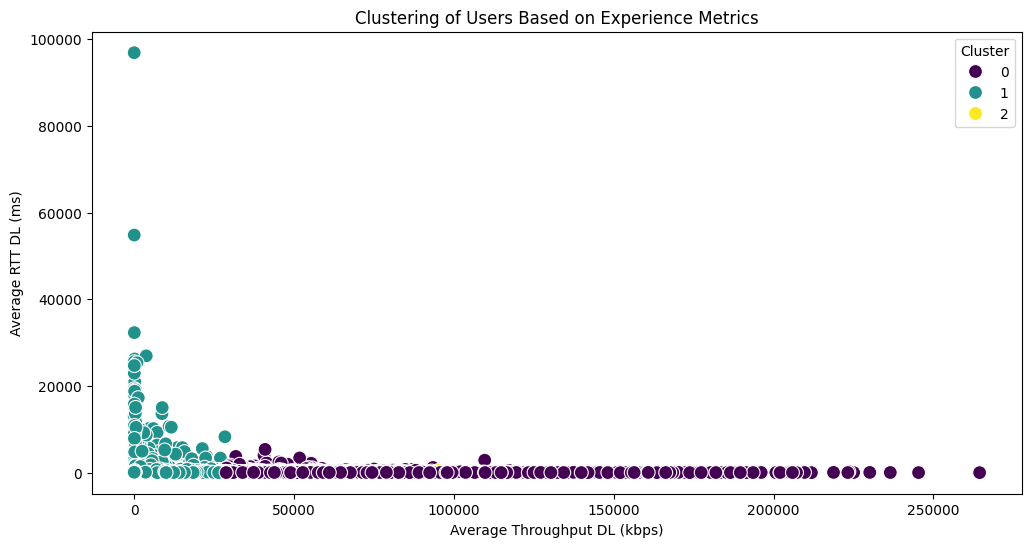

In [19]:
### Task 3.4 - K-Means Clustering
features = ['Avg TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Throughput DL (kbps)']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(aggregated_data[features])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
aggregated_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize Clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=aggregated_data['Avg Throughput DL (kbps)'],
    y=aggregated_data['Avg RTT DL (ms)'],
    hue=aggregated_data['Cluster'],
    palette='viridis',
    s=100
)
plt.title('Clustering of Users Based on Experience Metrics')
plt.xlabel('Average Throughput DL (kbps)')
plt.ylabel('Average RTT DL (ms)')
plt.legend(title='Cluster')
plt.show()

In [20]:
# Cluster Descriptions (Corrected)
numeric_features = ['Avg TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Throughput DL (kbps)']
cluster_descriptions = aggregated_data.groupby('Cluster')[numeric_features].mean()

print("\nCluster Descriptions:")
print(cluster_descriptions)


Cluster Descriptions:
         Avg TCP DL Retrans. Vol (Bytes)  Avg RTT DL (ms)  \
Cluster                                                     
0                           1.959627e+07        77.319787   
1                           1.625573e+07       126.372621   
2                           2.224330e+09       104.547799   

         Avg Throughput DL (kbps)  
Cluster                            
0                    49171.539659  
1                     3799.595727  
2                    62838.408386  


### **Task Outputs**

In [21]:
# Display Aggregated Data Table
print("\nAggregated Data (Sample):")
print(aggregated_data.head())


Aggregated Data (Sample):
   MSISDN/Number  Avg TCP DL Retrans. Vol (Bytes)  \
0   3.360100e+10                     2.080991e+07   
1   3.360100e+10                     2.080991e+07   
2   3.360100e+10                     2.080991e+07   
3   3.360101e+10                     1.066000e+03   
4   3.360101e+10                     1.507977e+07   

   Avg TCP UL Retrans. Vol (Bytes)  Avg RTT DL (ms)  Avg RTT UL (ms)  \
0                    759658.664811        46.000000         0.000000   
1                    759658.664811        30.000000         1.000000   
2                    759658.664811       109.795706        17.662883   
3                    759658.664811        69.000000        15.000000   
4                    390430.332406        57.000000         2.500000   

   Avg Throughput DL (kbps)  Avg Throughput UL (kbps)  \
0                      37.0                      39.0   
1                      48.0                      51.0   
2                      48.0                      4

In [22]:
# Display Top, Bottom, Most Frequent Values
print("\nTop 10 TCP Values:")
print(tcp_top)
print("\nBottom 10 TCP Values:")
print(tcp_bottom)
print("\nMost Frequent TCP Values:")
print(tcp_freq)


Top 10 TCP Values:
77982     4.294426e+09
135678    4.291380e+09
34645     4.289877e+09
140813    4.289488e+09
3782      4.288060e+09
119677    4.275259e+09
39637     4.268432e+09
76993     4.259997e+09
59016     4.256650e+09
41209     4.254644e+09
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Bottom 10 TCP Values:
59717     2.0
125091    2.0
2850      4.0
39610     4.0
52488     4.0
60376     4.0
60426     4.0
75095     4.0
100313    4.0
143429    4.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Most Frequent TCP Values:
TCP DL Retrans. Vol (Bytes)
2.080991e+07    88146
1.330000e+03      433
2.660000e+03      219
3.800000e+01      200
9.200000e+01      192
1.318000e+03      156
5.430000e+02      133
3.990000e+03      114
7.600000e+01      108
5.320000e+03      102
Name: count, dtype: int64


In [23]:
print("\nTop 10 RTT Values:")
print(rtt_top)
print("\nBottom 10 RTT Values:")
print(rtt_bottom)
print("\nMost Frequent RTT Values:")
print(rtt_freq)


Top 10 RTT Values:
30166     96923.0
29927     64640.0
17910     55811.0
5989      54847.0
22851     26971.0
23455     26250.0
1373      25873.0
81277     25602.0
97320     25374.0
100582    24733.0
Name: Avg RTT DL (ms), dtype: float64

Bottom 10 RTT Values:
42612     0.0
52225     0.0
60152     0.0
61152     0.0
61345     0.0
103326    0.0
124541    0.0
142526    0.0
143878    0.0
71739     2.0
Name: Avg RTT DL (ms), dtype: float64

Most Frequent RTT Values:
Avg RTT DL (ms)
109.795706    27829
28.000000      3553
27.000000      3380
34.000000      3296
35.000000      2892
37.000000      2718
36.000000      2645
38.000000      2547
29.000000      2498
26.000000      2488
Name: count, dtype: int64


In [24]:
print("\nTop 10 Throughput Values:")
print(throughput_top)
print("\nBottom 10 Throughput Values:")
print(throughput_bottom)
print("\nMost Frequent Throughput Values:")
print(throughput_freq)


Top 10 Throughput Values:
120884    378160.0
141262    299257.0
143670    299002.0
149617    276040.0
92198     269362.0
117784    266332.0
115843    265440.0
89579     264448.0
116558    263047.0
41576     254253.0
Name: Avg Bearer TP DL (kbps), dtype: float64

Bottom 10 Throughput Values:
13      0.0
149     0.0
364     0.0
546     0.0
618     0.0
679     0.0
756     0.0
809     0.0
893     0.0
1185    0.0
Name: Avg Bearer TP DL (kbps), dtype: float64

Most Frequent Throughput Values:
Avg Bearer TP DL (kbps)
23.0    7324
43.0    4352
44.0    4186
6.0     3983
22.0    2867
48.0    2778
63.0    2757
42.0    2689
45.0    2644
47.0    2263
Name: count, dtype: int64
